# File 06: Model Making and Training

This file has been the most frustrating and the most fun to make. I'vs tried to simplify everything as much as I could. The dataframe we use to train and evaluate our model in this file is already preprocessed. Therefore, without wasting anytime we move on to creating our tokenizer. The tokenizer has a word limit of 4000 words. This tokenizer is then used to convert tweets into an integer vector(basically an array of numbers). But not all tweets are of the same length. Therefore, we pad the every tweet with 0 to make it all a consistent length. This file, the input_length or the length of the tweet happens to 48. Once the model is trained, we plot the curves for accuracy and loss comparing graphs from training and validation. This will give us an idea of if the model is underfitting, overfitting or needs no adjustment. After saving the graphs, we move on to saving the models with their weights to ensure we can use it whenever we wish to.

### Important Values:
- max_features = 4000
- embed_dim = 128
- lstm_out = 196
- batch_size = 256
- epochs = 10
- input_size = 48 -----> maximum length of tweet available in 'X'

### Input Files:
- 04-train-data.csv

### Output Files:
- tokenizer.pickle
- model-sa/model-cpu.yaml
- model-sa/model-gpu.yaml
- model-sa/model-weights-cpu.h5
- model-sa/model-weights-gpu.h5

### Steps:
1. load required libraries
1. loading the training dataset
1. creating the tokenizer
1. Creating 'X' and 'Y' arrays
1. Spliting 'X' and 'Y' into training and validation datasets
1. making cpu-based machine learning model
1. training our first model
1. making gpu-based machine learning model
1. training our second model
1. function to test and save the model with weigths
1. function to load the model - just in case

In [1]:
# load required libraries

import re
import keras
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import save_model, load_model
from keras.models import model_from_yaml

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
# loading the training dataset

data = pd.read_csv('db/04-train-data.csv')
data = data[['TEXT', 'SENTIMENT']]
data = data.dropna(subset=['TEXT'])
data = data.sample(frac=1).reset_index(drop=True)

In [3]:
# creating the tokenizer

max_features = 4000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['TEXT'].values)

# saving the tokenizer
with open('model-sa/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading the tokenizer
# with open('model-sa/tokenizer.pickle', 'rb') as handle:
#     new_tokeinzer = pickle.load(handle)

In [4]:
# Creating 'X' and 'Y' arrays

X = tokenizer.texts_to_sequences(data['TEXT'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['SENTIMENT']).values

In [5]:
# Spliting 'X' and 'Y' into training and validation datasets

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
X_train = X_train.reshape(1259100, 48)
Y_train = Y_train.reshape(1259100, 2)
X_test = X_test.reshape(314775, 48)
Y_test = Y_test.reshape(314775, 2)

In [6]:
# making cpu-based machine learning model

embed_dim = 128
lstm_out = 196

model1 = Sequential()
model1.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model1.add(SpatialDropout1D(0.4))
model1.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model1.add(SpatialDropout1D(0.4))
model1.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(2,activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 128)           512000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 48, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 48, 196)           254800    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 48, 196)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               308112    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 1,075,306
Trainable params: 1,075,306
Non-trainable params: 0
______________________________________________

In [7]:
history1 = model1.fit(X_train, Y_train, epochs = 10, batch_size = 256, verbose = 1, validation_split=0.2)

Train on 1007280 samples, validate on 251820 samples
Epoch 1/10
1007280/1007280 [==============================] - 407s 404us/sample - loss: 0.4770 - accuracy: 0.7715 - val_loss: 0.4550 - val_accuracy: 0.7845
Epoch 2/10
1007280/1007280 [==============================] - 404s 401us/sample - loss: 0.4548 - accuracy: 0.7847 - val_loss: 0.4493 - val_accuracy: 0.7884
Epoch 3/10
1007280/1007280 [==============================] - 407s 404us/sample - loss: 0.4472 - accuracy: 0.7891 - val_loss: 0.4441 - val_accuracy: 0.7908
Epoch 4/10
1007280/1007280 [==============================] - 440s 437us/sample - loss: 0.4416 - accuracy: 0.7923 - val_loss: 0.4416 - val_accuracy: 0.7928
Epoch 5/10
1007280/1007280 [==============================] - 403s 400us/sample - loss: 0.4369 - accuracy: 0.7948 - val_loss: 0.4412 - val_accuracy: 0.7935
Epoch 6/10
1007280/1007280 [==============================] - 407s 404us/sample - loss: 0.4332 - accuracy: 0.7971 - val_loss: 0.4383 - val_accuracy: 0.7948
Epoch 7/10


In [10]:
# making gpu-based machine learning model

embed_dim = 128
lstm_out = 196

model2 = Sequential()
model2.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model2.add(SpatialDropout1D(0.4))
model2.add(CuDNNLSTM(lstm_out, return_sequences=True))
model2.add(SpatialDropout1D(0.4))
model2.add(CuDNNLSTM(lstm_out))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 128)           512000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 48, 128)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 48, 196)           255584    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 48, 196)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 196)               308896    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394       
Total params: 1,076,874
Trainable params: 1,076,874
Non-trainable params: 0
____________________________________________

In [11]:
history2 = model2.fit(X_train, Y_train, epochs = 10, batch_size = 256, verbose = 1, validation_split=0.2)

Train on 1007280 samples, validate on 251820 samples
Epoch 1/10
1007280/1007280 [==============================] - 78s 77us/sample - loss: 0.4730 - accuracy: 0.7729 - val_loss: 0.4563 - val_accuracy: 0.7835
Epoch 2/10
1007280/1007280 [==============================] - 76s 76us/sample - loss: 0.4513 - accuracy: 0.7865 - val_loss: 0.4463 - val_accuracy: 0.7896
Epoch 3/10
1007280/1007280 [==============================] - 77s 76us/sample - loss: 0.4430 - accuracy: 0.7914 - val_loss: 0.4420 - val_accuracy: 0.7924
Epoch 4/10
1007280/1007280 [==============================] - 76s 76us/sample - loss: 0.4363 - accuracy: 0.7949 - val_loss: 0.4397 - val_accuracy: 0.7937
Epoch 5/10
1007280/1007280 [==============================] - 77s 76us/sample - loss: 0.4307 - accuracy: 0.7987 - val_loss: 0.4381 - val_accuracy: 0.7947
Epoch 6/10
1007280/1007280 [==============================] - 77s 76us/sample - loss: 0.4256 - accuracy: 0.8014 - val_loss: 0.4382 - val_accuracy: 0.7950
Epoch 7/10
1007280/1007

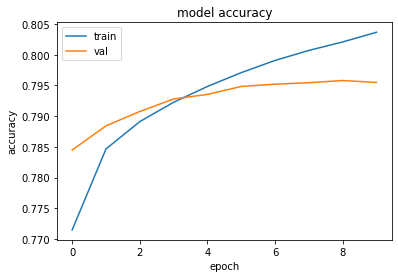

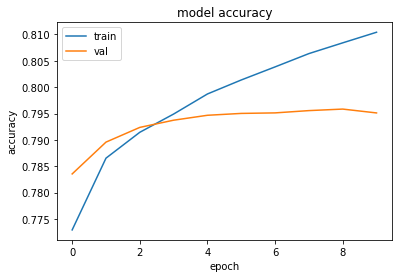

In [12]:
# function to save accuracy graphs

def save_accuracy_plot(history, name="accuracy.png") :
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(name)
    plt.show()
    
save_accuracy_plot(history1, "graphs/cpu-accuracy.png")
save_accuracy_plot(history2, "graphs/gpu-accuracy.png")

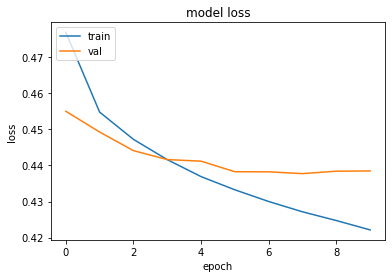

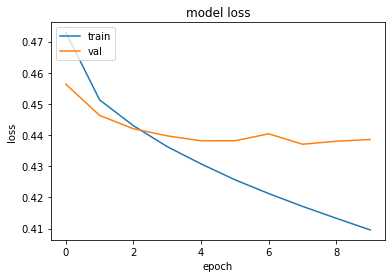

In [13]:
# function to save loss graphs

def save_loss_plot(history, name="loss.png") :
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(name)
    plt.show()
    
save_loss_plot(history1, "graphs/cpu-loss.png")
save_loss_plot(history2, "graphs/gpu-loss.png")

In [14]:
# function to test and save the model with weigths

def test_and_save(model, name) :
    
    # test model
    score = model.evaluate(X_test, Y_test, verbose=1)
    print(f"Evaluation Results :")
    print(f"Loss    : {score[0]}")
    print(f"Accuracy: {score[1]}\n")
    
    # saving model as a yaml file
    yaml = model.to_yaml()
    with open("".join(["model-sa/model-", name, ".yaml"]), 'w') as file:
        file.write(yaml)
      
    # saving model weights
    model.save_weights("".join(["model-sa/weights-", name, ".h5"]))
    
    
test_and_save(model1, "cpu")
test_and_save(model2, "gpu")

314775/314775 [==============================] - 201s 640us/sample - loss: 0.4403 - accuracy: 0.7944
Evaluation Results :
Loss    : 0.44027372315522456
Accuracy: 0.7944214344024658

314775/314775 [==============================] - 38s 120us/sample - loss: 0.4410 - accuracy: 0.7944
Evaluation Results :
Loss    : 0.4409663168700994
Accuracy: 0.7944404482841492



In [15]:
# function to load the model - just in case

def load_model(model, weight) :
    with open(model, 'r') as file:
        yaml_model = file.read()
    
    model = tf.keras.models.model_from_yaml(yaml_model)
    model.load_weights(weight)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# loaded1 = load_model(
#     "model-sa/model-yaml-cpu.yaml", 
#     "model-sa/model-weights-cpu.h5"
# )

# loaded2 = load_model(
#     "model-sa/model-yaml-gpu.yaml", 
#     "model-sa/model-weights-gpu.h5"
# )

In [16]:
# loaded1.evaluate(X_test[:1000], Y_test[:1000], verbose=1)
# loaded2.evaluate(X_test[:1000], Y_test[:1000], verbose=1)